In [4]:
import torch  # 导入PyTorch库，用于深度学习模型的构建和训练
from torch import nn  # 从PyTorch库中导入神经网络模块，用于构建神经网络层
from d2l import torch as d2l  # 从d2l（动手学深度学习）库中导入torch模块，并重命名为d2l

# 定义一个VGG块的函数，返回一个由多个卷积层和池化层构成的神经网络模块
# vgg_block: VGG网络块 (VGG block)
# num_convs: 卷积层的数量 (number of convolutions)
# in_channels: 输入通道数 (input channels)
# out_channels: 输出通道数 (output channels)
def vgg_block(num_convs, in_channels, out_channels):
    # 初始化一个空列表，用于存放每一层的层对象
    layers = []  # layers: 层的列表 (list of layers)
    
    # 使用for循环，根据num_convs的值添加指定数量的卷积层
    # 每次循环都添加一个卷积层和一个ReLU激活函数
    # _ 是占位符，表示我们不需要使用循环变量
    for _ in range(num_convs):
        # 添加卷积层到layers列表中
        # Conv2d: 卷积层 (Convolutional layer)
        # kernel_size=3 表示3*3的卷积核
        # padding=1 表示在输入的周围添加1像素的边框，以保持输出尺寸不变
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))  # Conv2d: 卷积层
        
        # 添加ReLU激活函数到layers列表中
        # ReLU: 整流线性单元 (Rectified Linear Unit)
        layers.append(nn.ReLU())  # ReLU: 激活函数
        
        # 将当前的输出通道数赋值给下一次卷积层的输入通道数
        in_channels = out_channels  # 更新输入通道数
    
    # 添加最大池化层，用于减少特征图的尺寸
    # MaxPool2d: 最大池化层 (Max Pooling layer)
    # kernel_size=2 表示2*2的池化窗口
    # stride=2 表示池化窗口每次移动2个像素
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # MaxPool2d: 最大池化层
    
    # 使用nn.Sequential将层的列表转换为一个按顺序运行的神经网络模块
    return nn.Sequential(*layers)  # Sequential: 顺序容器 (Sequential container)


In [5]:
# 原始VGG网络有5个块    
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [6]:
# 定义VGG网络结构
# vgg: VGG网络 (Visual Geometry Group Network)
# conv_arch: 卷积架构 (convolution architecture)，存储了每一层卷积块的配置（卷积层数和输出通道数）
def vgg(conv_arch):  
    # 初始化空列表，用于存储构建好的卷积块
    conv_blks = []  # conv_blks: 卷积块列表 (list of convolutional blocks)
    
    # 设置输入通道数为1，表示灰度图像的单通道输入
    in_channels = 1  # in_channels: 输入通道数 (input channels)
    
    # 卷积层部分 (Convolutional Block Section)
    # 遍历卷积架构conv_arch，每个元素是一个元组，包含卷积层的数量(num_convs)和输出通道数(out_channels)
    for (num_convs, out_channels) in conv_arch:
        # 根据卷积层数量和输入、输出通道数，添加卷积块到conv_blks列表
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))  # 添加卷积块 (add convolution block)
        
        # 更新输入通道数为当前块的输出通道数，以便下一个卷积块使用
        in_channels = out_channels  # 更新输入通道数 (update input channels)

    # 返回一个顺序容器，构建包含卷积层和全连接层的完整VGG网络
    return nn.Sequential(
        # 将所有卷积块展开并传入Sequential中
        *conv_blks,  # 卷积块部分 (convolution block part)
        
        # 扁平化层，将卷积层的输出展平为一维向量
        nn.Flatten(),  # Flatten: 扁平化层 (flattening layer)
        
        # 全连接层部分 (Fully Connected Layer Section)
        # 输入尺寸为out_channels * 7 * 7，即最后一个卷积层输出的大小，输出4096个节点
        nn.Linear(out_channels * 7 * 7, 4096),  # Linear: 全连接层 (fully connected layer)
        nn.ReLU(),  # ReLU激活函数 (Rectified Linear Unit)
        nn.Dropout(0.5),  # Dropout: 随机失活层 (Dropout Layer) 防止过拟合
        
        # 第二个全连接层，输入4096个节点，输出仍为4096个节点
        nn.Linear(4096, 4096),  # 全连接层 (fully connected layer)
        nn.ReLU(),  # ReLU激活函数
        
        # 第二个Dropout层，防止过拟合，保持50%概率的节点失活
        nn.Dropout(0.5),  # Dropout层 (Dropout Layer)
        
        # 输出层，输出10个类别，用于分类任务
        nn.Linear(4096, 10)  # Linear: 输出层 (output layer)
    )

# 使用定义好的卷积架构创建VGG网络
net = vgg(conv_arch)  # 创建VGG网络 (create VGG network)


In [7]:
# 构建一个高度和宽度为224的单通道数据样本，以观察每个层输出的形状。
X = torch.randn(size=(1, 1, 224, 224))  # 生成随机张量X，大小为(1, 1, 224, 224)
# torch: PyTorch库，用于深度学习的框架
# randn: 生成标准正态分布的随机数
# size: 大小，张量的形状
# X: 输入张量，大小为1个样本，1个通道，高度224，宽度224

for blk in net:  # 遍历网络中的每个块（blk）
# blk: 网络中的每个模块（block），用于处理输入数据
# net: 神经网络模型

    X = blk(X)  # 将输入X传递给当前块（blk）进行前向传播
    # blk(X): 模块blk对输入X进行处理，通常是卷积、池化等操作

    print(blk.__class__.__name__, 'output shape:\t', X.shape)  
    # 打印当前块的类名及其输出张量的形状
    # blk.__class__.__name__: 获取当前块的类名（即模块类型，如卷积层、池化层等）
    # X.shape: 输出张量X的形状
    # output shape: 输出的形状，用于检查网络的输出尺寸


    """把网络分为5个块，每一次把通道数翻倍，把高宽减半，空间压缩时模式数翻倍"""


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [8]:
ratio = 4  # 定义比例变量ratio，值为4
# ratio: 比例，用于缩小通道数
# channels除以4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]  
# 使用比例缩减卷积架构中的通道数
# small_conv_arch: 缩减后的卷积架构，存储每层卷积层的通道数
# conv_arch: 原始卷积架构，包含每层卷积层的通道数
# pair: 每层卷积架构中的一对数值，(卷积类型, 输出通道数)
# pair[0]: 卷积类型（如卷积层、池化层）
# pair[1]: 输出通道数，使用 // ratio（整除）进行缩小

net = vgg(small_conv_arch)  
# 使用缩小后的卷积架构构建VGG网络
# net: 使用缩小后的卷积架构生成的神经网络
# vgg: VGG网络的构造函数，基于给定的卷积架构生成VGG模型


KeyboardInterrupt: 

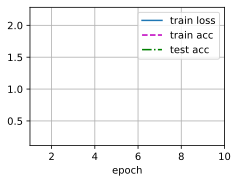

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 128  


train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)  
# 加载Fashion-MNIST数据集，返回训练集和测试集的迭代器
# resize: 图像大小调整为224×224像素

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())  
# 使用指定的参数训练神经网络
# d2l: 深度学习库
# train_ch6: 训练函数，特定于第六章（Chapter 6）的模型训练函数
# net: 神经网络模型
# train_iter: 训练数据迭代器
# test_iter: 测试数据迭代器
# num_epochs: 总训练轮数
# lr: 学习率
# d2l.try_gpu(): 尝试使用GPU进行训练，如果GPU可用，则使用GPU
